In [1]:
import os
import math

import torch
import gpytorch

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import sklearn.gaussian_process as gp
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def filterinitialset (filename, headername = "vibrational level v\Temperature(K)",  \
    factor = 1.0, normalize = False):

    dfin = pd.read_excel(filename)

    #print(dfin)
    
    dfdict = {}
    
    tempvalues = list(dfin.columns[1:])
    vibvalues = list(dfin[headername].values)

    min = float("inf")
    max = float("-inf")
    for c in dfin.columns:
        dfdict[c] = []
        if c == headername:
            dfdict[c] = list(dfin[c].values)
        else:
            for v in dfin[c].values:
                val = factor*v
                if val > max:
                    max = val
                if val < min:
                    min = val

    for c in dfin.columns:
        if c != headername:
            for v in dfin[c].values:
                val = factor*v
                valp = (val - min) / (max - min)
                if normalize:
                    dfdict[c].append(valp)
                else:
                    dfdict[c].append(val)

    df = pd.DataFrame.from_dict(dfdict)

    return df, vibvalues, tempvalues

##############################################################################

def plotfull3dcurve (df, vib_values, temp_values):

    y = []
    x = []
    for t in temp_values:
        for idx in range(len(vib_values)):
            x.append([float(t), float(vib_values[idx])])
            y.append(df[t].values[idx])

    X = np.array(x)
    Y = np.array(y)

    xdim = len(temp_values)
    ydim = len(vib_values)

    Xp = np.zeros((xdim, ydim), dtype=float)
    Yp = np.zeros((xdim, ydim), dtype=float)
    Zp = np.zeros((xdim, ydim), dtype=float)
    for xidx in range(xdim):
        t = temp_values[xidx]
        for yidx in range(ydim):
            v =  vib_values[yidx]
            Xp[xidx, yidx] = float(t)
            Yp[xidx, yidx] = float(v)
            Zp[xidx, yidx] = df[t].values[yidx]

    #fig = plt.figure(figsize=(10,8))
    fig = plt.figure(figsize=plt.figaspect(2.))
    plt.gcf().set_size_inches(40, 30)
    ax = fig.add_subplot(2,1,1, projection='3d')
    surf = ax.plot_surface(Xp, Yp, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
    plt.show()

##########################################################################################################3

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

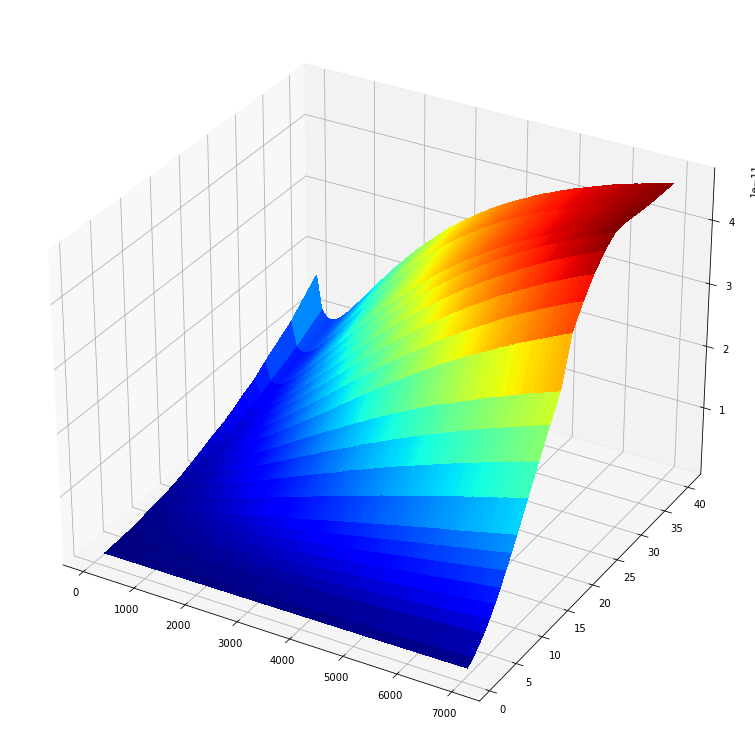

In [3]:
filename = "N2N2_dataset.xls"
df, vib_values , temp_values = filterinitialset (filename)
plotfull3dcurve (df, vib_values, temp_values)

In [4]:
def fitusinggpt (train_x, train_y, minx, maxx):
         # initialize likelihood and model
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = ExactGPModel(train_x, train_y, likelihood)

        smoke_test = ('CI' in os.environ)
        training_iter = 2 if smoke_test else 100
    
        # Find optimal model hyperparameters
        model.train()
        likelihood.train()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
                ))
            optimizer.step()

        # Get into evaluation (predictive posterior) mode
        model.eval()
        likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            test_x = torch.linspace(minx, maxx, 150, dtype=torch.float64)
            print("Test points: ", test_x)
            #print(test_x.shape, type(test_x))
            #print(type(model))
            observed_pred = likelihood(model(test_x))

        with torch.no_grad():
            # Initialize plot
            f, ax = plt.subplots(1, 1, figsize=(4, 3))

            # Get upper and lower confidence bounds
            lower, upper = observed_pred.confidence_region()
            #print(lower.numpy().shape)
            #print(test_x.numpy().shape)
            #print(upper.numpy().shape)
            # Plot training data as black stars
            ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
            # Plot predictive means as blue line
            ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
            # Shade between the lower and upper confidence bounds
            ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
            # ax.set_ylim([-3, 3])
            ax.legend(['Observed Data', 'Mean', 'Confidence'])
            plt.gcf().set_size_inches(15, 10)
            plt.show()

#To use GPy

train_x = torch.linspace(0, 1, len(temp_values), dtype=torch.float64)
train_y = torch.linspace(0, 1, len(temp_values), dtype=torch.float64)

maxt = max(temp_values)
mint = min(temp_values)

normalizevalues = True

for vibidx, selectedvib in enumerate(vib_values[13:14]):

    maxy = float("-inf")
    miny = float("+inf")
    
    for idx, t in enumerate(temp_values):
        yval = df[t].values[vibidx]

        if yval < miny:
            miny = yval
        elif yval > maxy:
            maxy = yval

    for idx, t in enumerate(temp_values):
        tval = t 
        if normalizevalues:
            tval = (t - mint)/(maxt - mint)
        train_x[idx] = tval
        
        yval = df[t].values[vibidx]
        #yval = math.log(yval)
        if normalizevalues:
            train_y[idx] = (yval - miny)/(maxy - miny)
        else:
            train_y[idx] = yval

    print("V = " + str(selectedvib))
    minx = torch.min(train_x)
    maxx = torch.max(train_x)
    print("Xval range: ", minx, maxx)

    print("Yval range: ", torch.min(train_y), torch.max(train_y))

    fitusinggpt (train_x, train_y, minx, maxx)

In [5]:
def fitusingscikitl (train_x, train_y, minx, maxx):

    #train_x = in_train_x.numpy().reshape(-1, 1)
    #train_y = in_train_y.numpy()

    #rom sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

    #kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

    #kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1)
    #kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * \
    #     gp.kernels.RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))

    #kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * gp.kernels.RBF( length_scale_bounds=(1e-2, 1e5))

    kernel = gp.kernels.ConstantKernel(1.0, (1e-5, 1e5))* gp.kernels.RBF(length_scale=1)
    #kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * gp.kernels.RBF([5,5], (1e-2, 1e2))
    #kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * \
    #    gp.kernels.RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))

    #l = 0.1
    #sigma_f = 2
    #kernel = gp.kernels.ConstantKernel(constant_value=sigma_f,constant_value_bounds=(1e-3, 1e3)) \
    #            * gp.kernels.RBF(length_scale=l, length_scale_bounds=(1e-3, 1e3))
    # *  gp.kernels.ExpSineSquared(length_scale=1, periodicity=2)

    #kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * gp.kernels.PairwiseKernel(metric='rbf')
    #maternParams = {'length_scale': 1.0, 'nu': 1.5}
    #kernel = gp.kernels.Matern(**maternParams)
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, \
        normalize_y=False)
    print("Start training ")
    #model = RandomForestRegressor()
    model.fit(train_x, train_y)
    print("Done ")

    return model

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 6.29862e-05
Max Stdev 1.43120e-03


/home/redo/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


<Figure size 432x288 with 0 Axes>

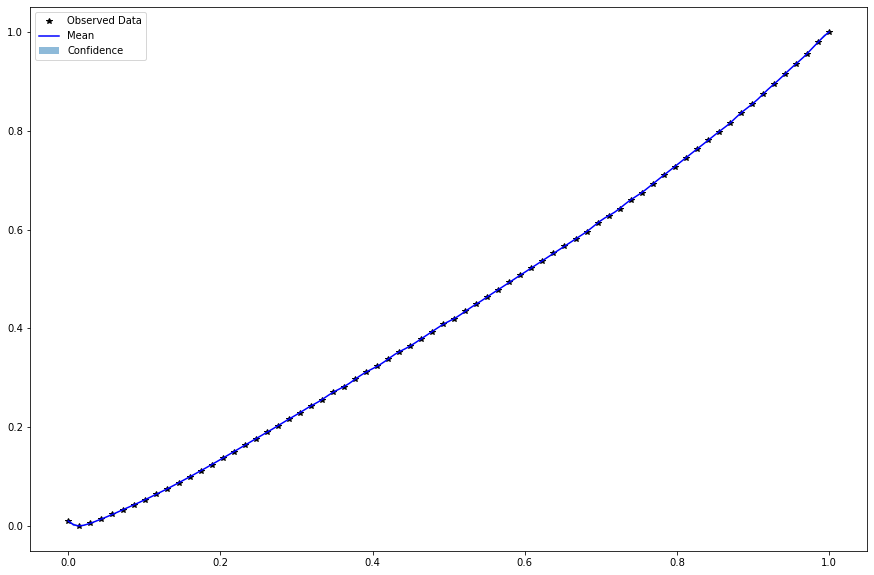

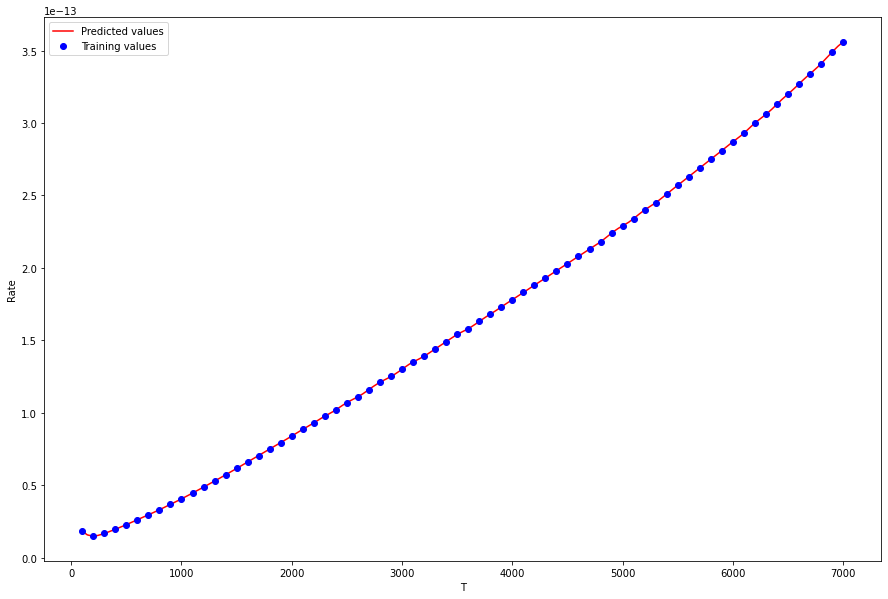

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 5.00069e-05
Max Stdev 1.20111e-03


<Figure size 432x288 with 0 Axes>

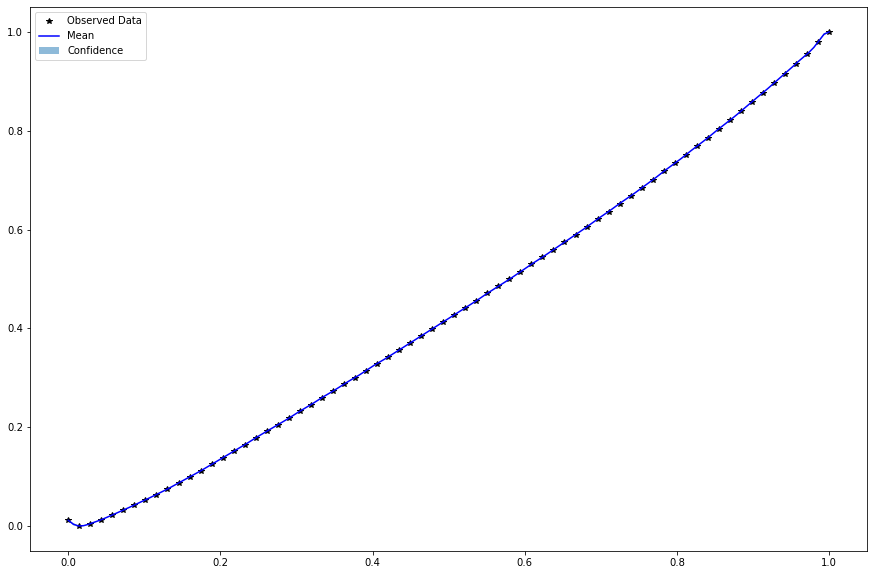

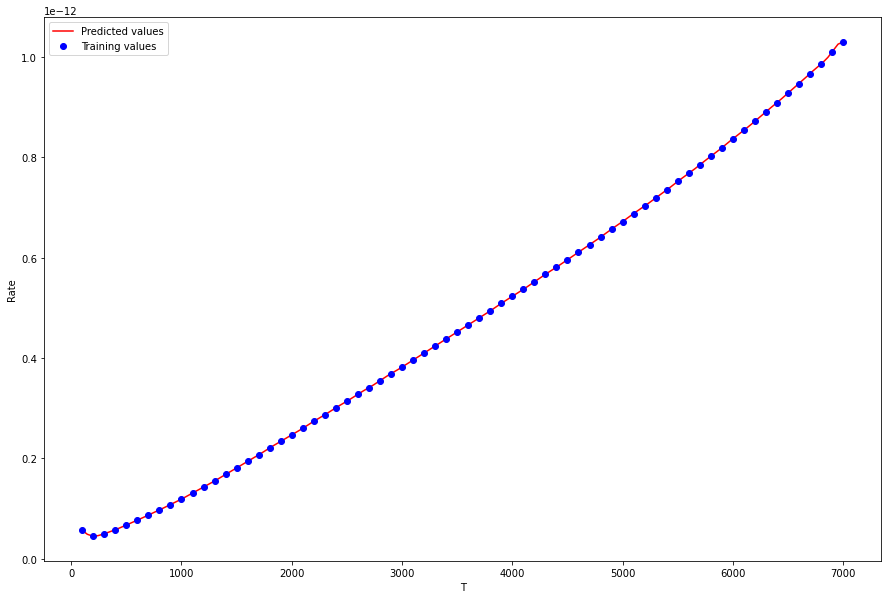

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 1.22311e-04
Max Stdev 2.25442e-03


<Figure size 432x288 with 0 Axes>

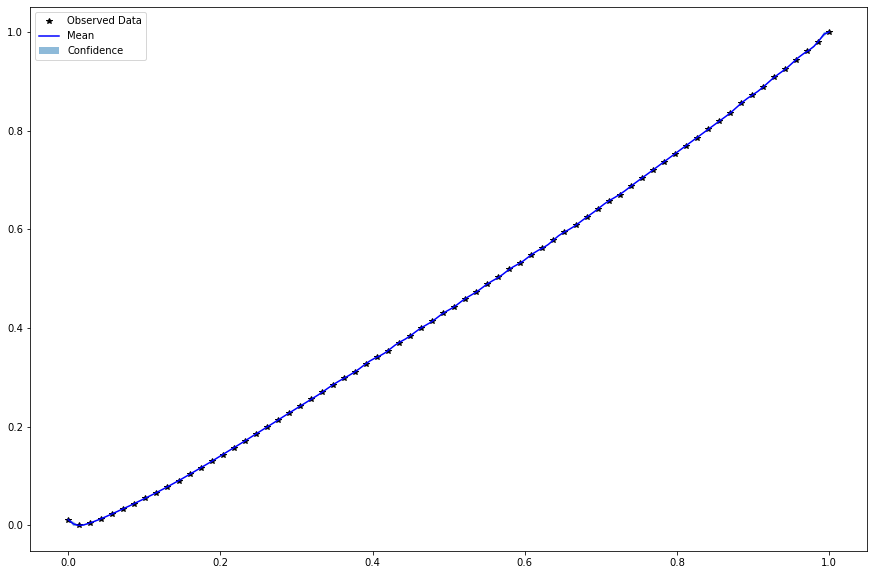

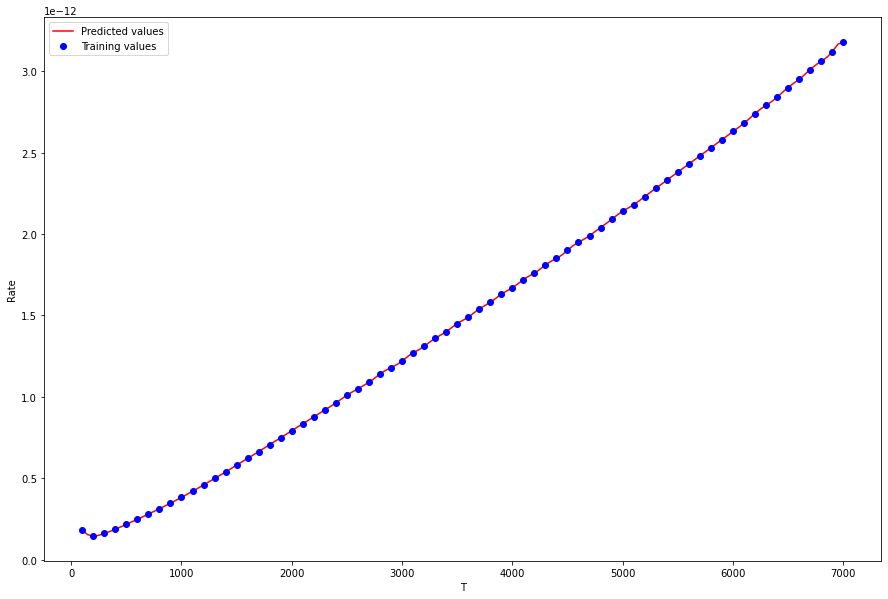

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 7.98565e-05
Max Stdev 1.70747e-03


<Figure size 432x288 with 0 Axes>

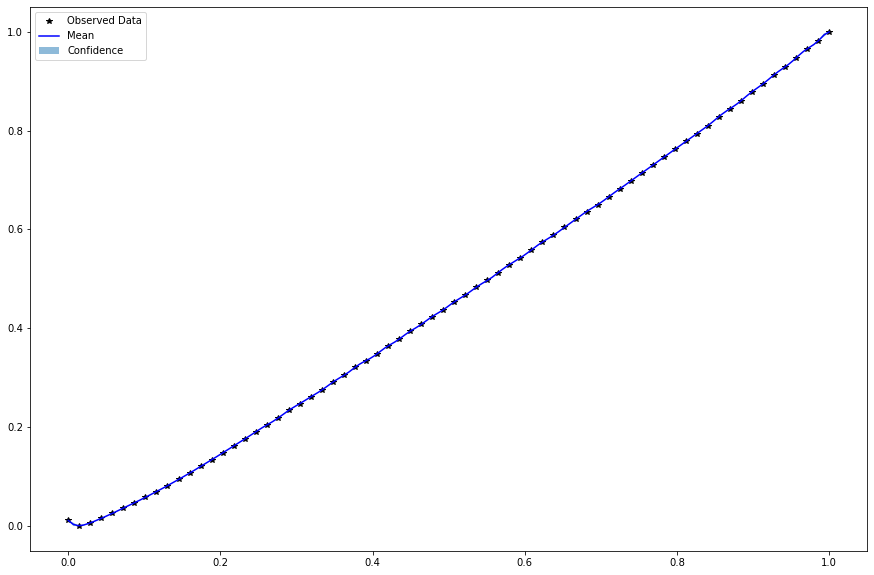

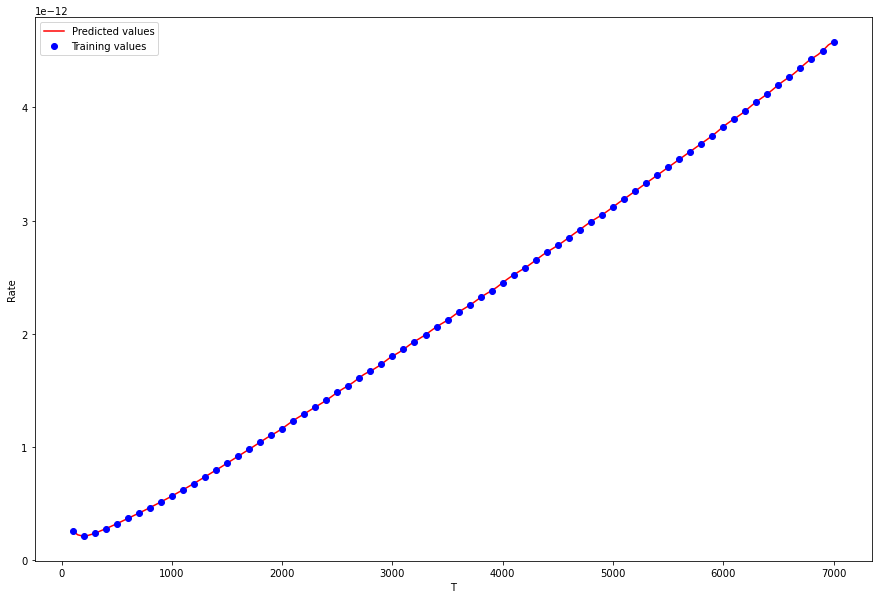

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 3.50288e-05
Max Stdev 9.06403e-04


<Figure size 432x288 with 0 Axes>

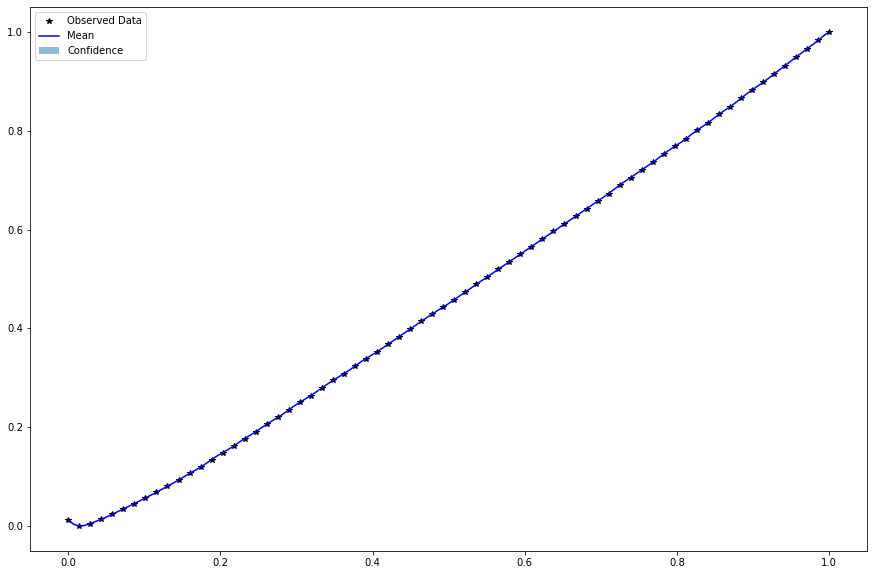

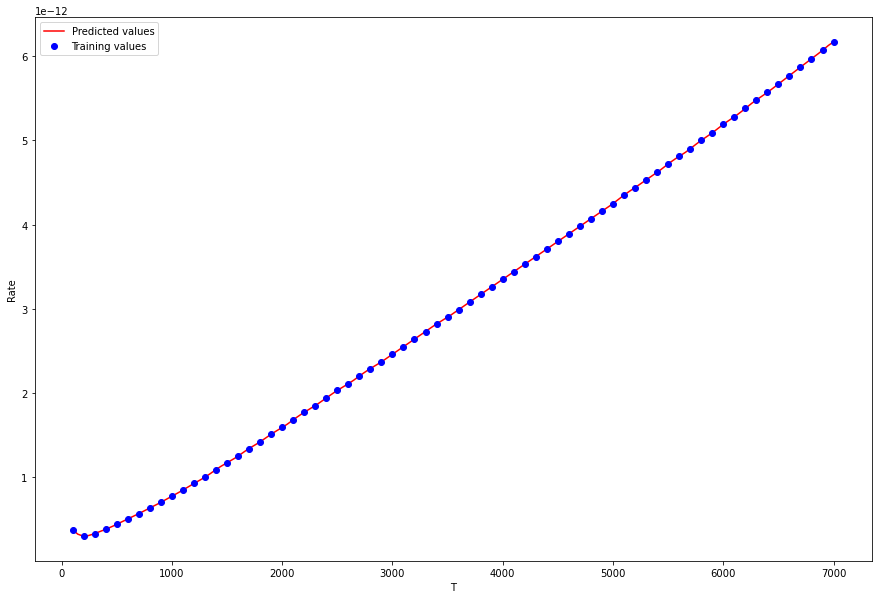

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 6.55095e-05
Max Stdev 1.49317e-03


<Figure size 432x288 with 0 Axes>

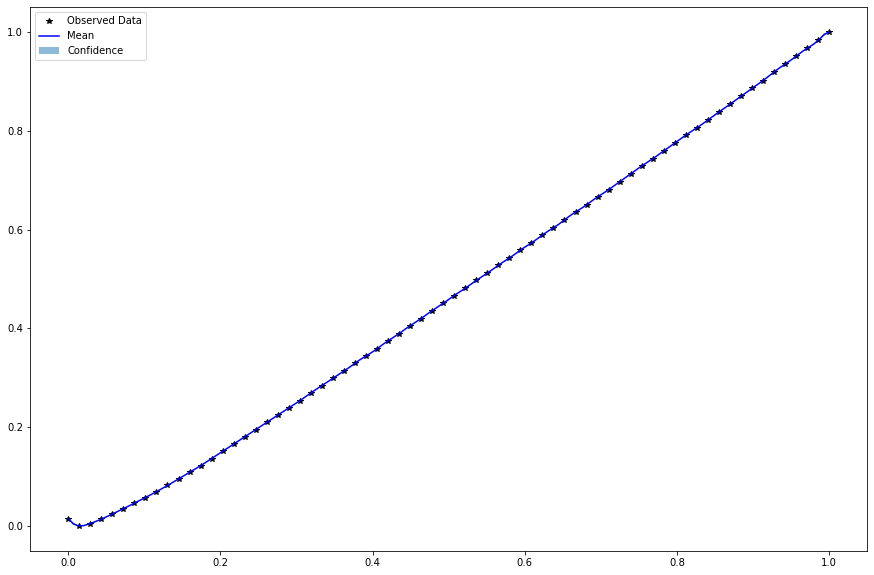

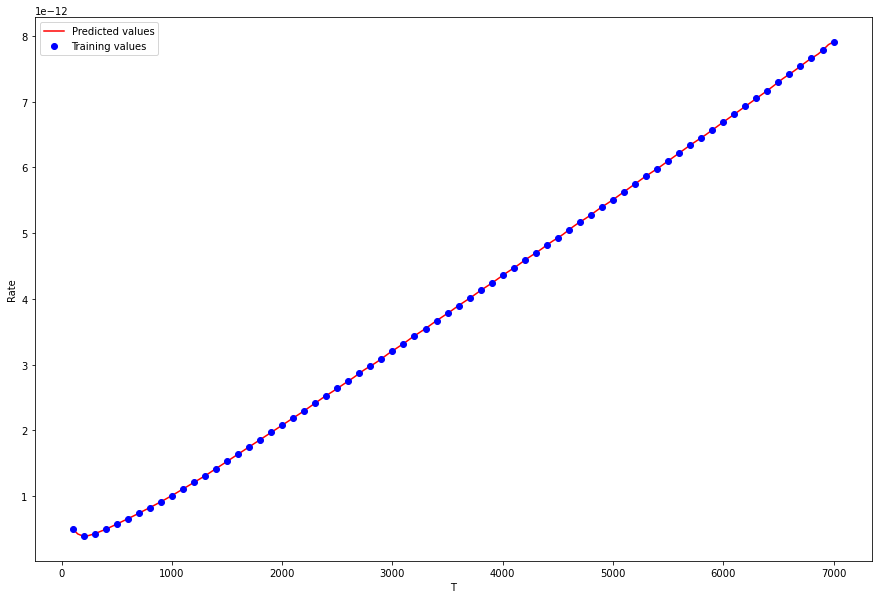

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 3.87752e-05
Max Stdev 9.91484e-04


<Figure size 432x288 with 0 Axes>

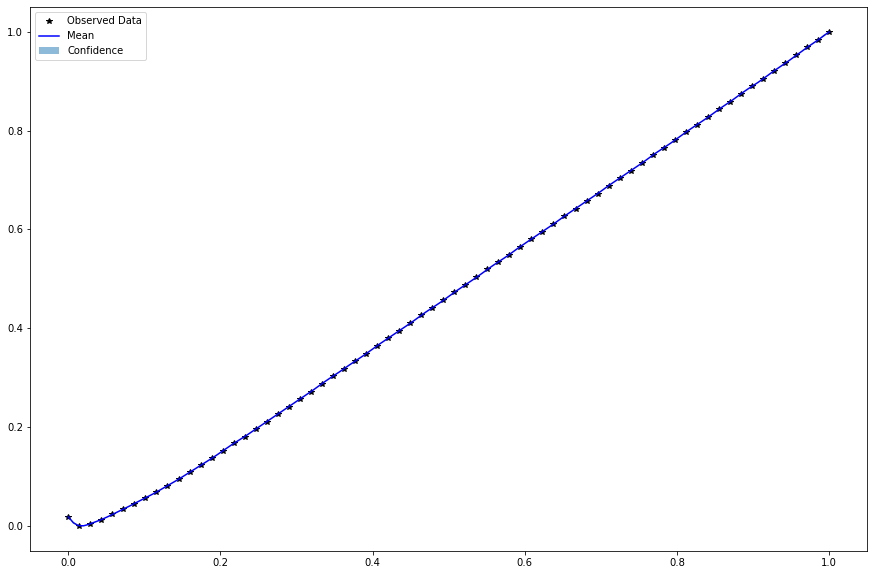

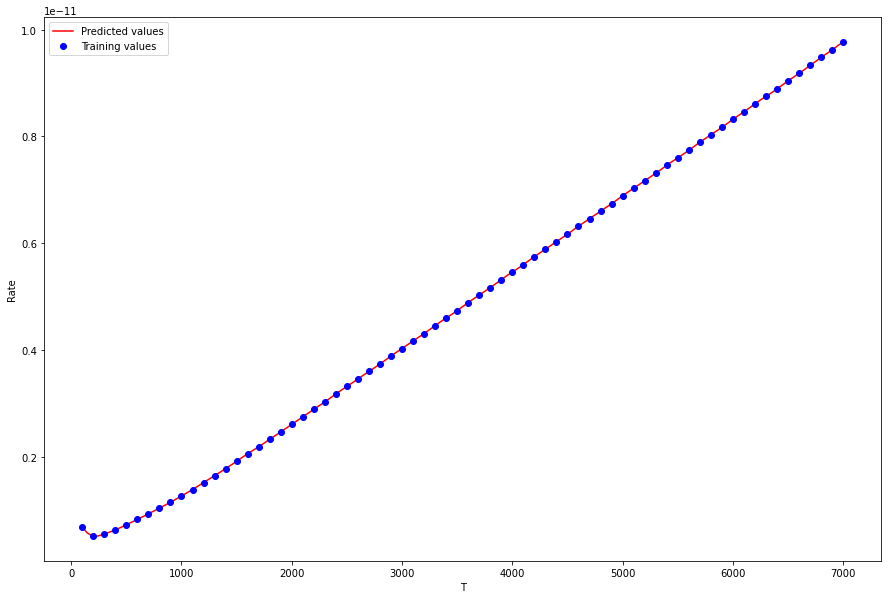

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 4.11528e-05
Max Stdev 1.04240e-03


<Figure size 432x288 with 0 Axes>

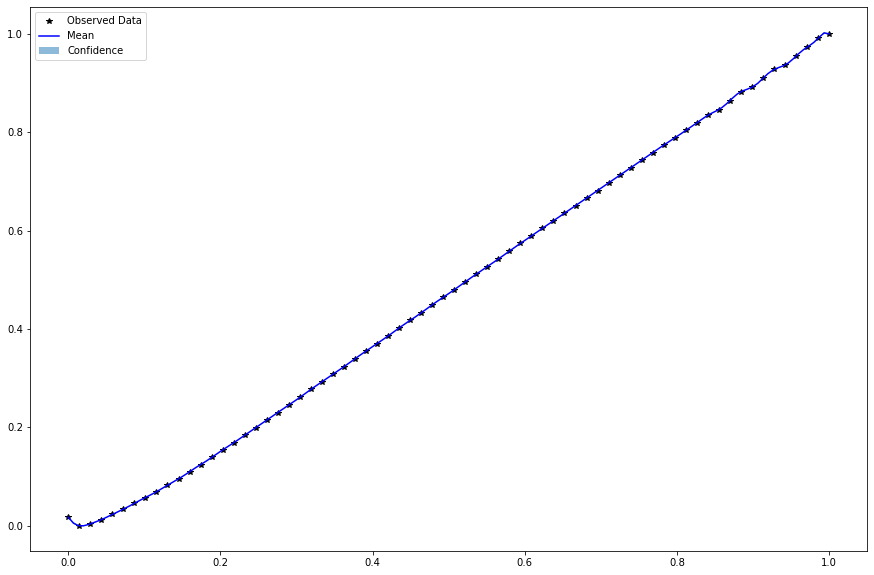

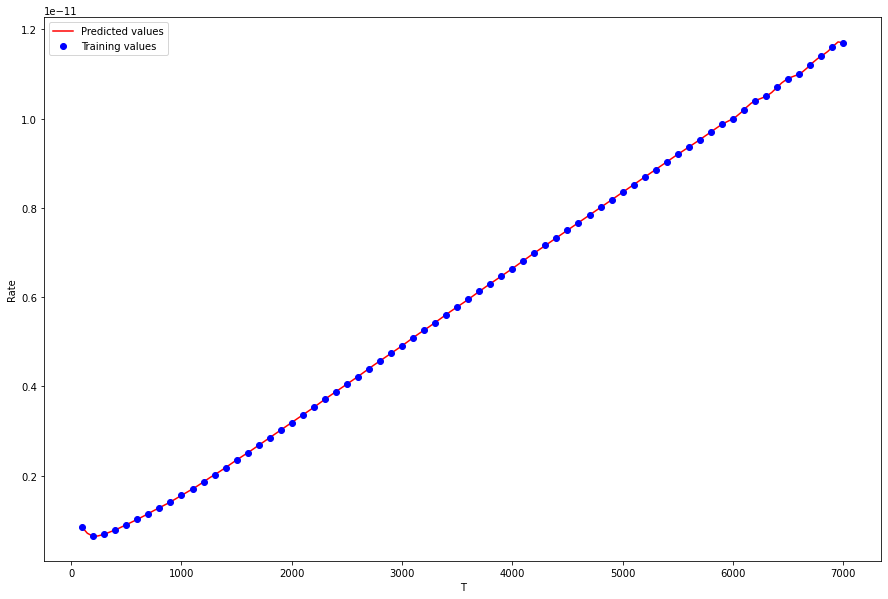

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 7.28201e-05
Max Stdev 1.62122e-03


<Figure size 432x288 with 0 Axes>

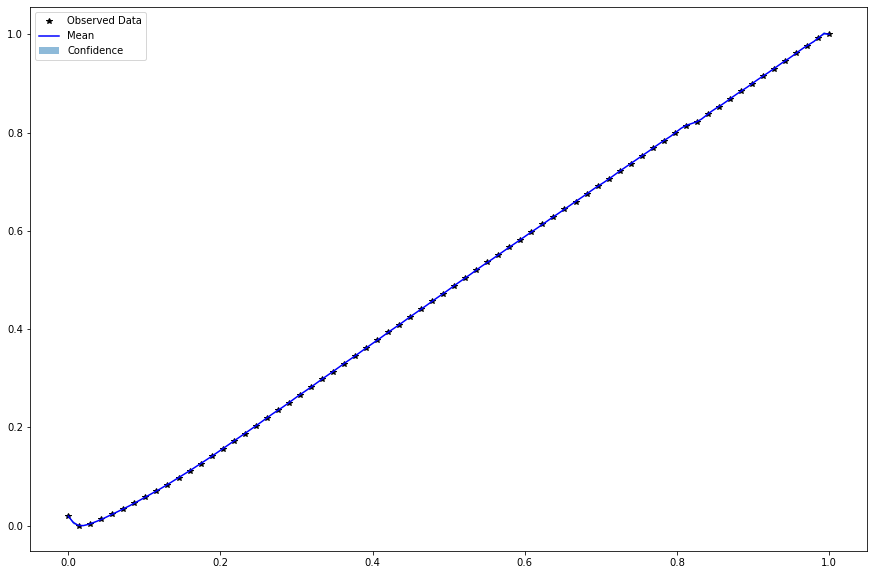

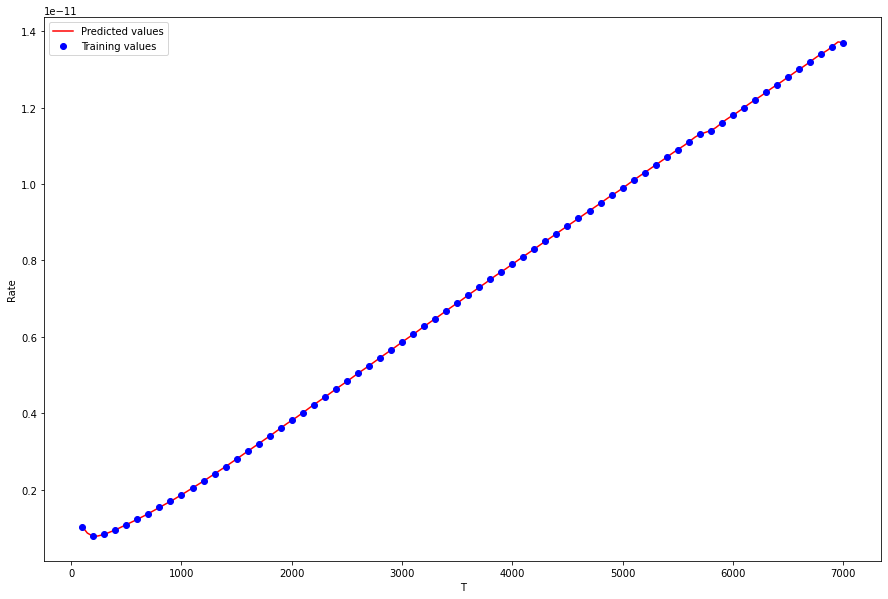

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 1.97377e-04
Max Stdev 3.12354e-03


<Figure size 432x288 with 0 Axes>

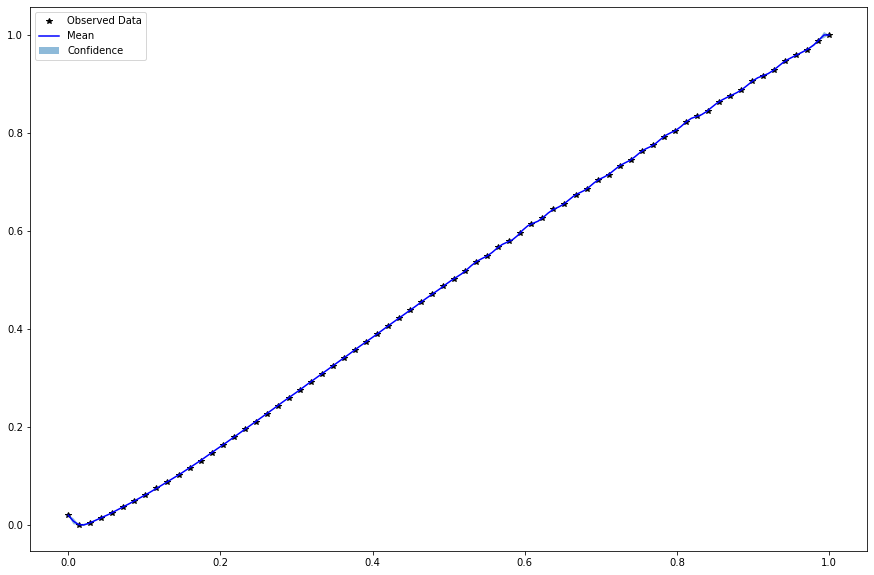

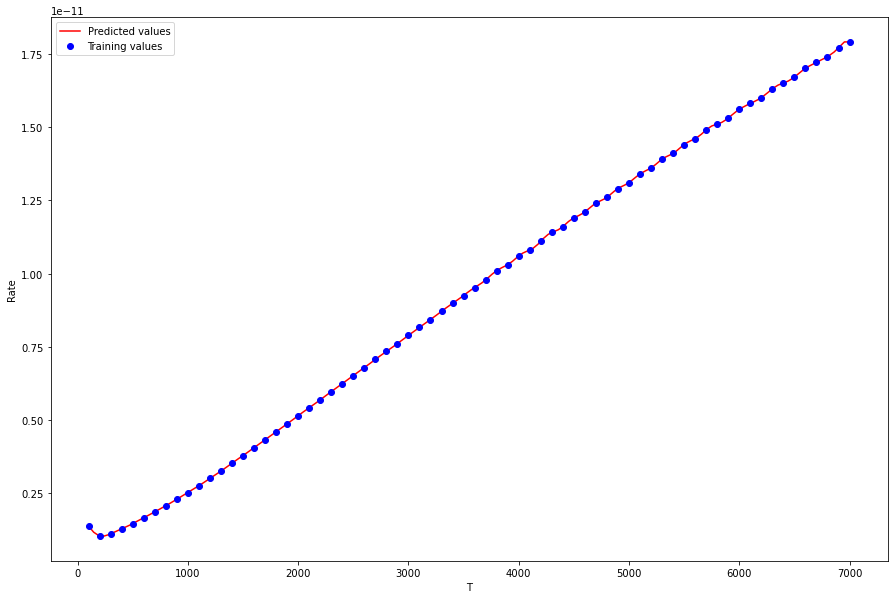

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 8.00818e-05
Max Stdev 1.75812e-03


<Figure size 432x288 with 0 Axes>

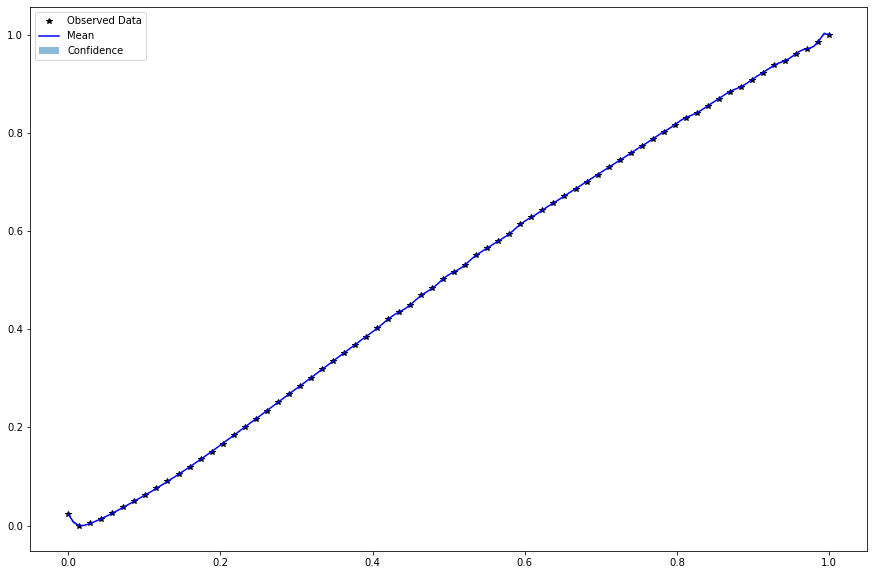

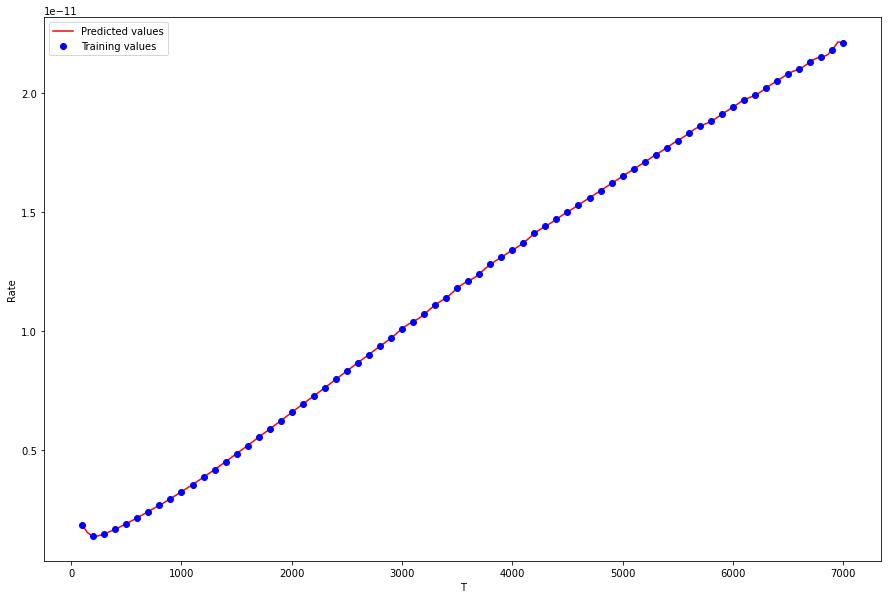

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 


/home/redo/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Done 
Avg Stdev 1.23900e-04
Max Stdev 2.34638e-03


<Figure size 432x288 with 0 Axes>

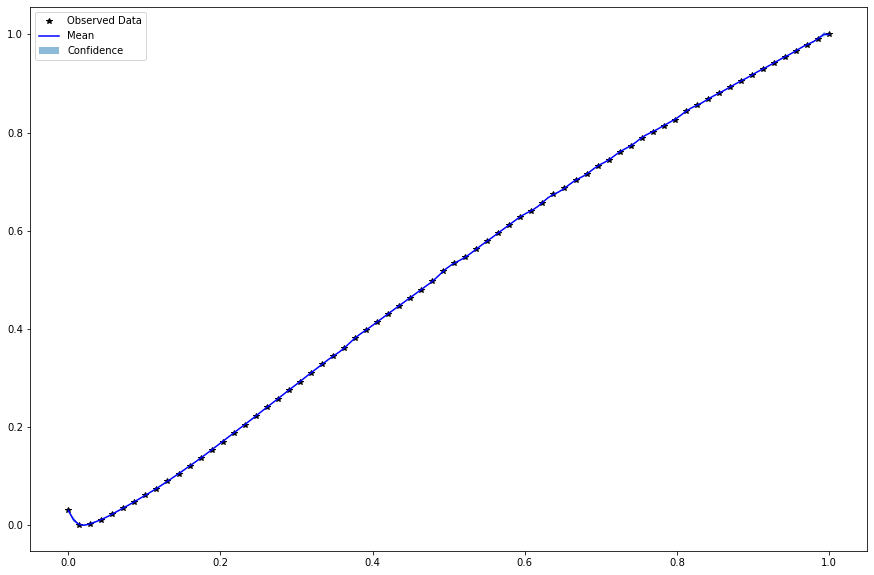

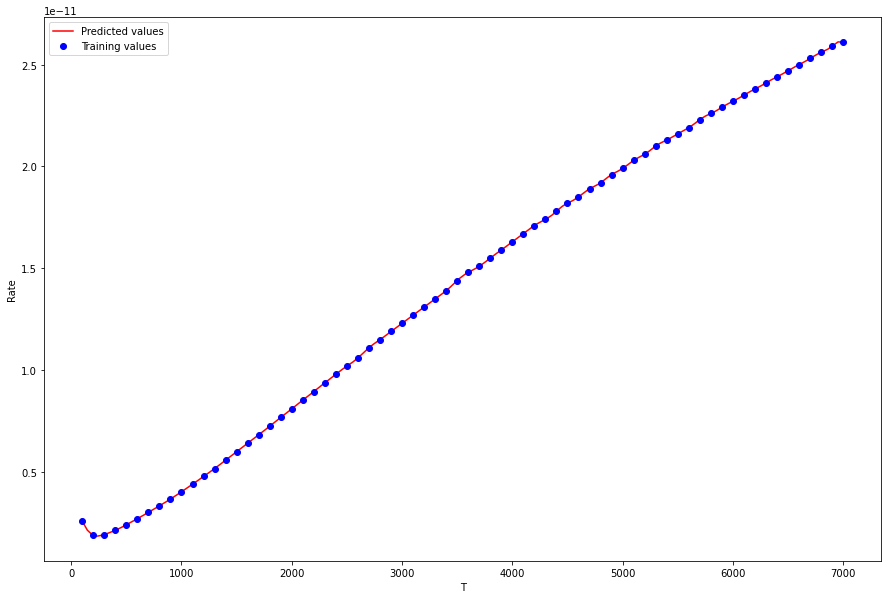

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 4.31569e-05
Max Stdev 1.11545e-03


<Figure size 432x288 with 0 Axes>

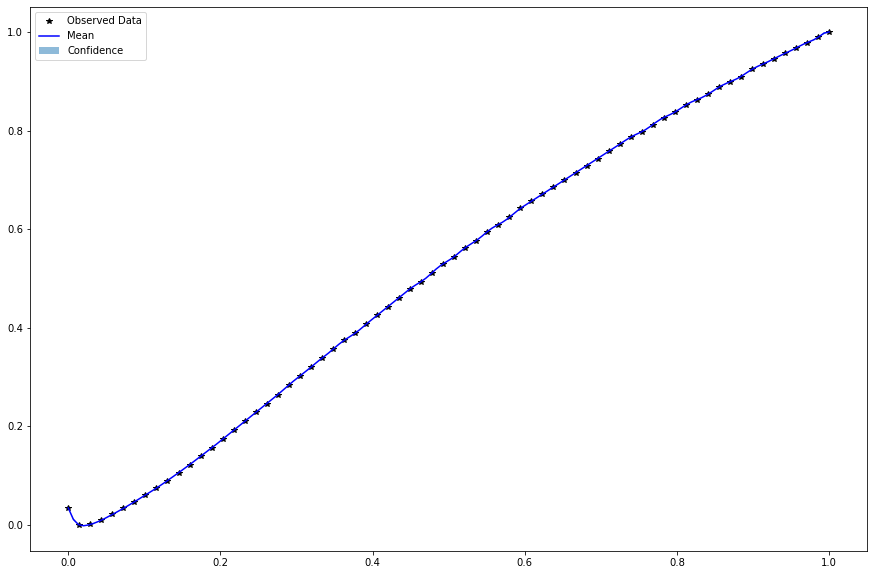

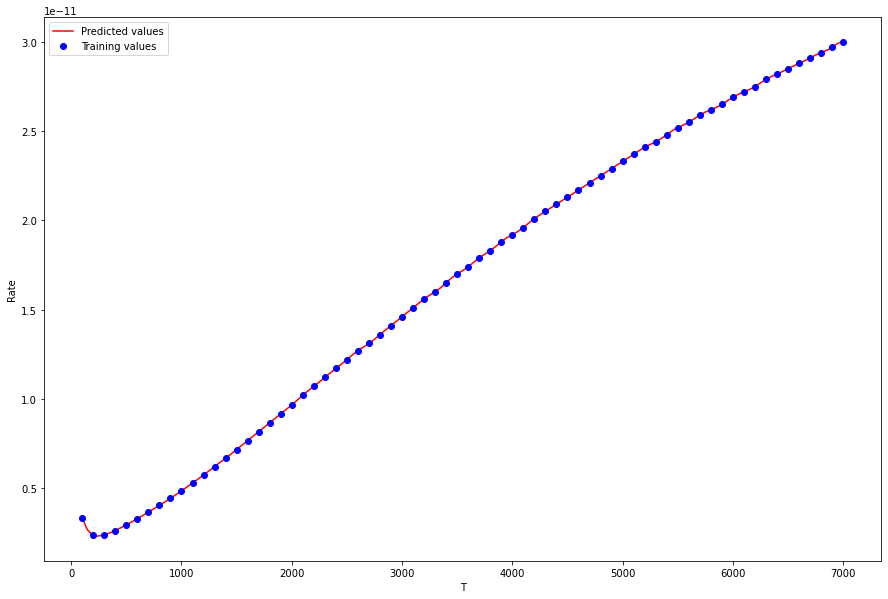

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 


/home/redo/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Done 
Avg Stdev 5.16084e-05
Max Stdev 1.28120e-03


<Figure size 432x288 with 0 Axes>

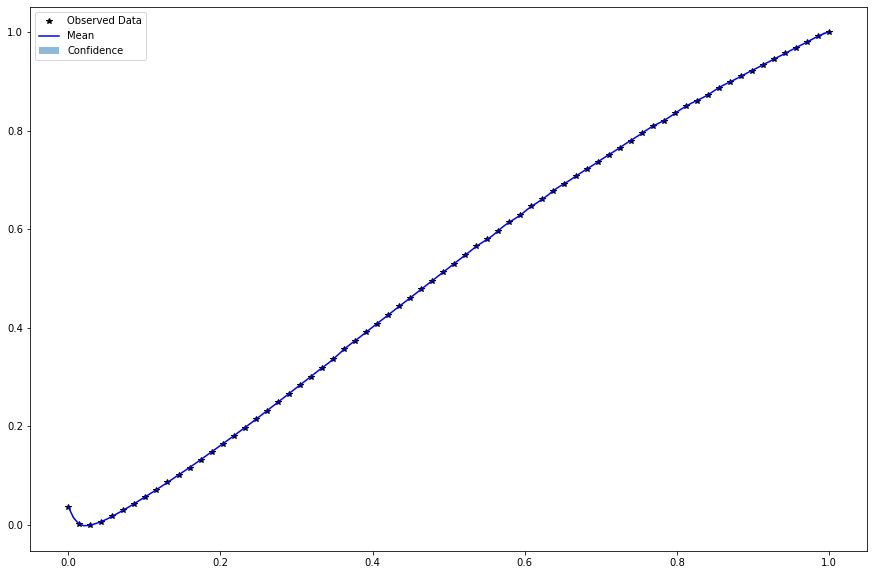

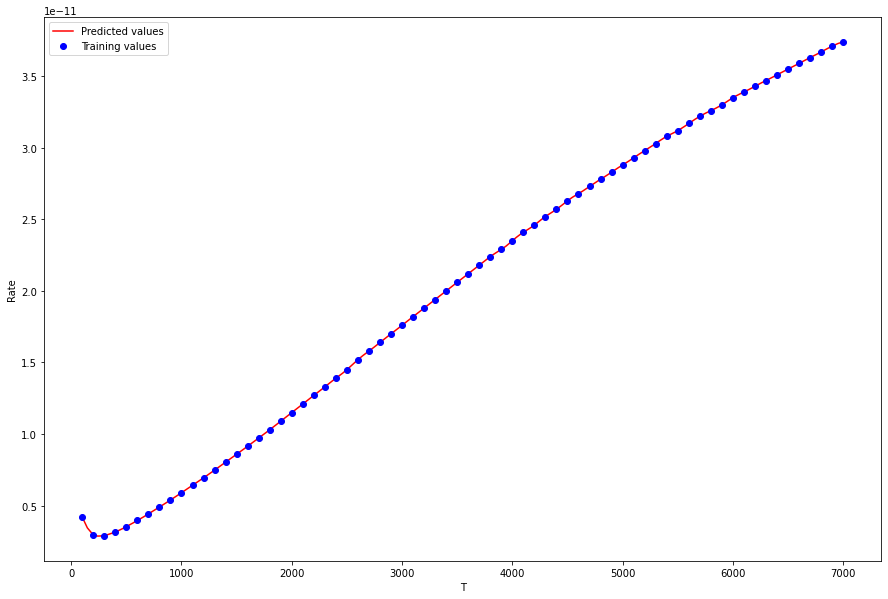

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 7.72570e-05
Max Stdev 1.72548e-03


<Figure size 432x288 with 0 Axes>

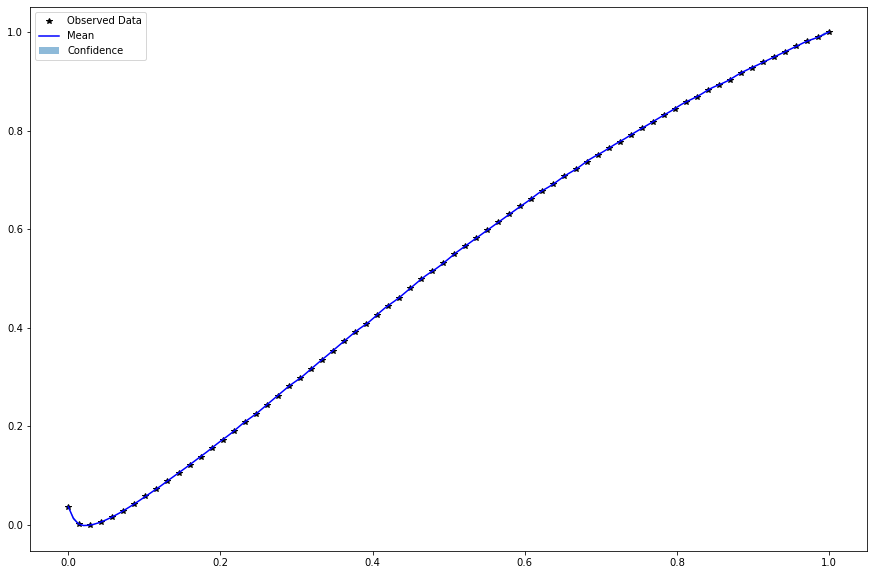

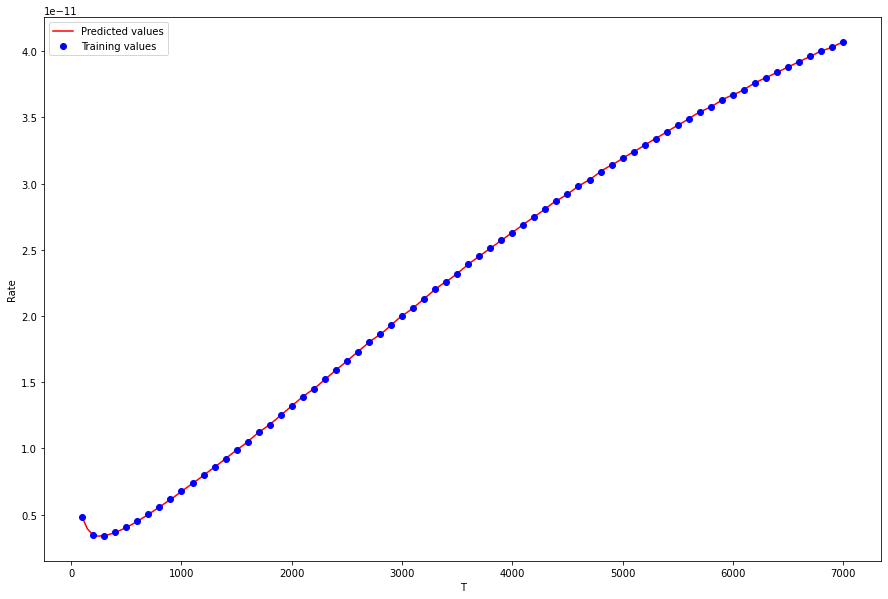

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 9.14055e-05
Max Stdev 1.94002e-03


<Figure size 432x288 with 0 Axes>

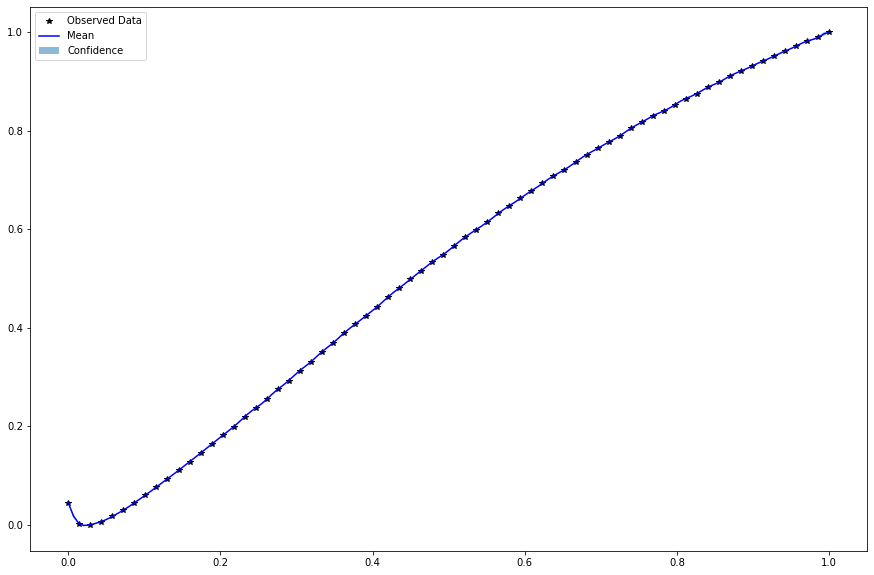

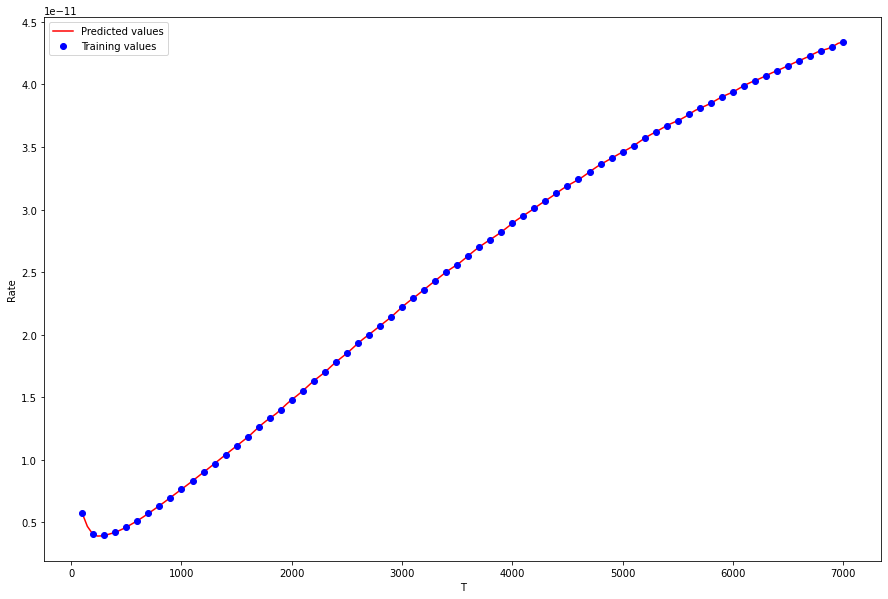

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 7.81386e-05
Max Stdev 1.76243e-03


<Figure size 432x288 with 0 Axes>

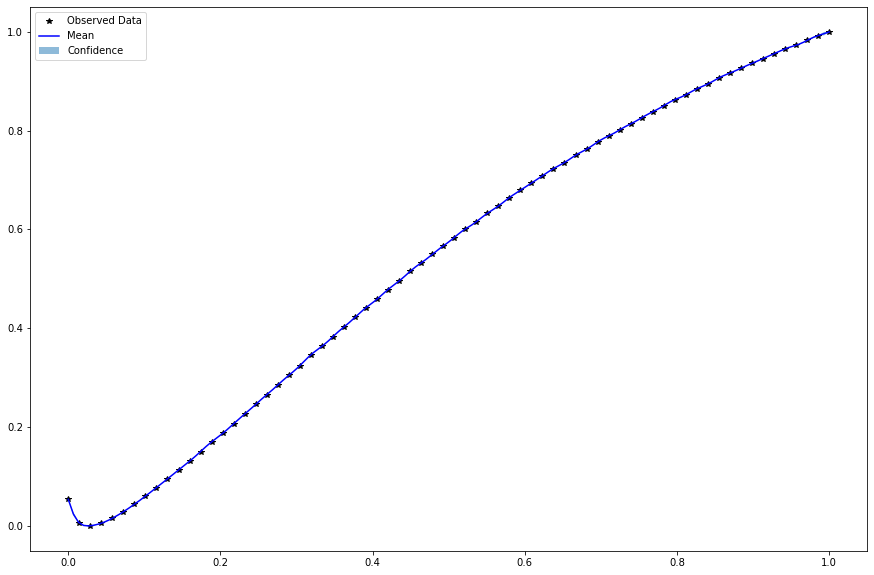

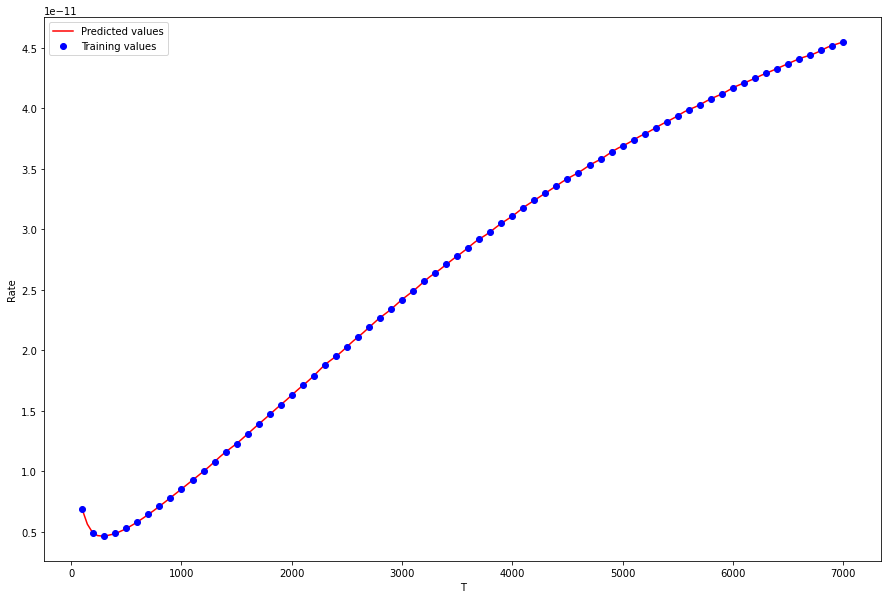

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 7.61547e-05
Max Stdev 1.72466e-03


<Figure size 432x288 with 0 Axes>

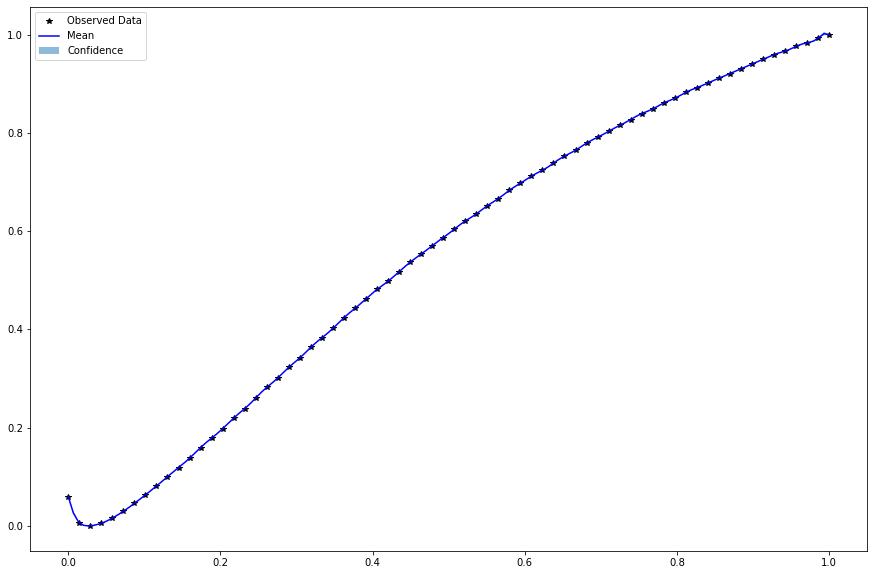

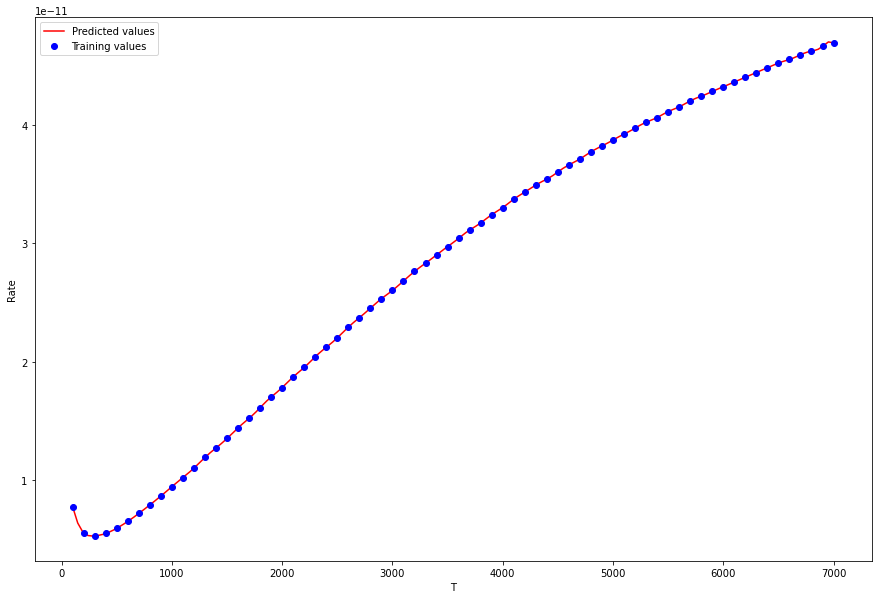

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 8.66604e-05
Max Stdev 1.89993e-03


<Figure size 432x288 with 0 Axes>

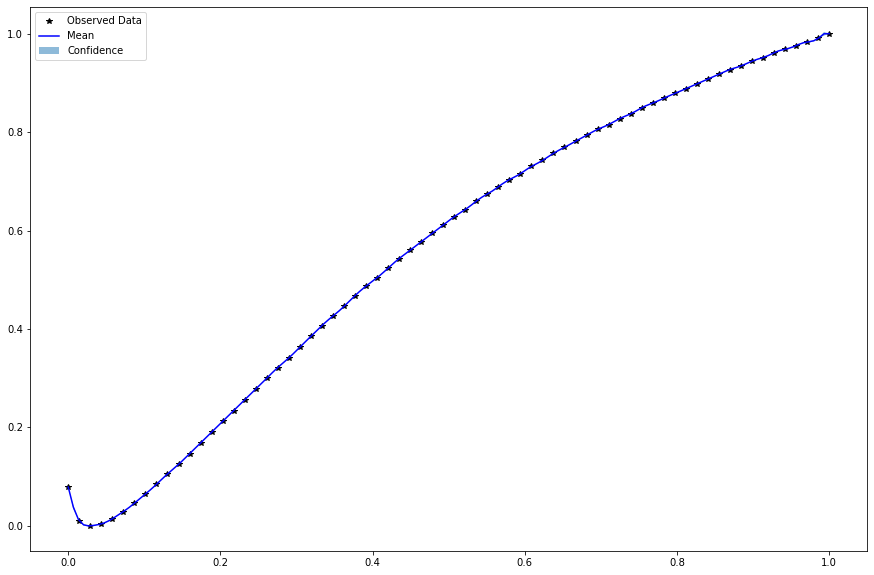

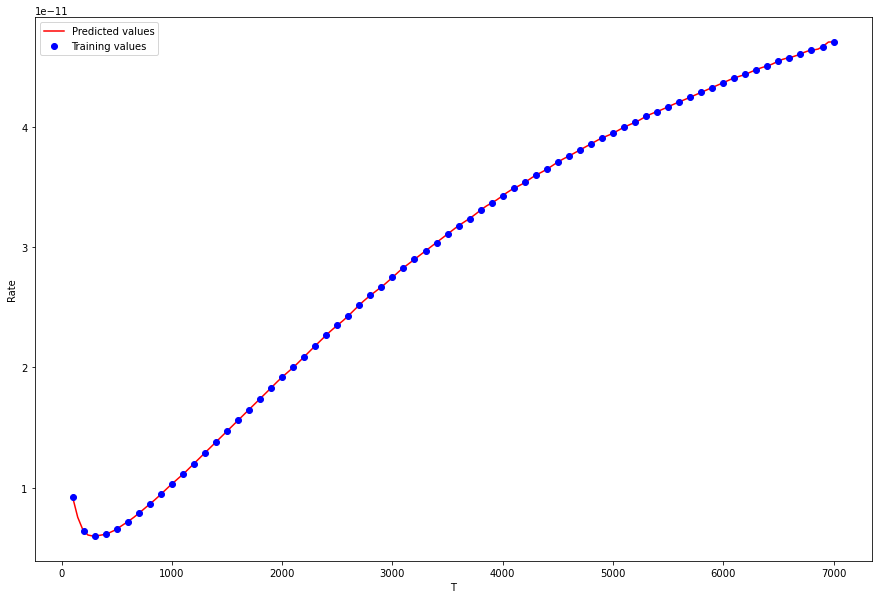

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 9.73172e-05
Max Stdev 2.09847e-03


<Figure size 432x288 with 0 Axes>

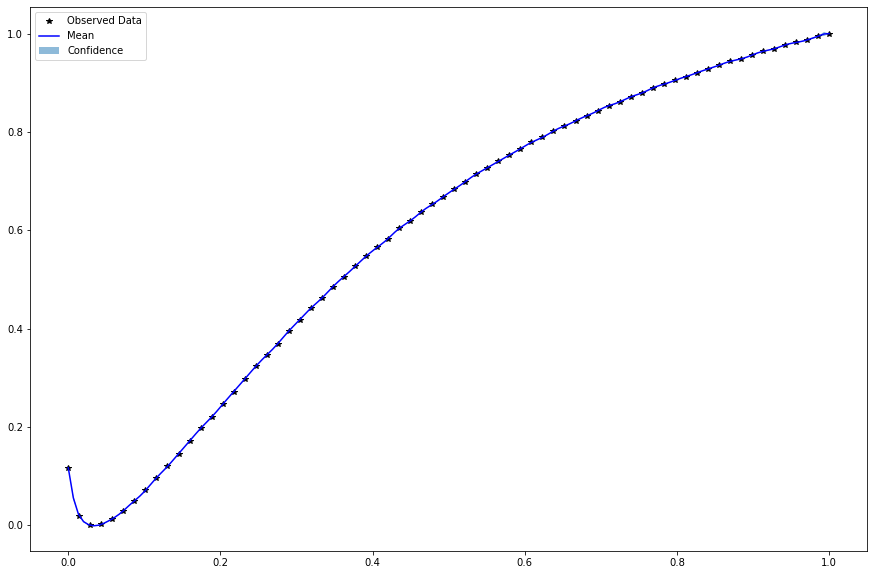

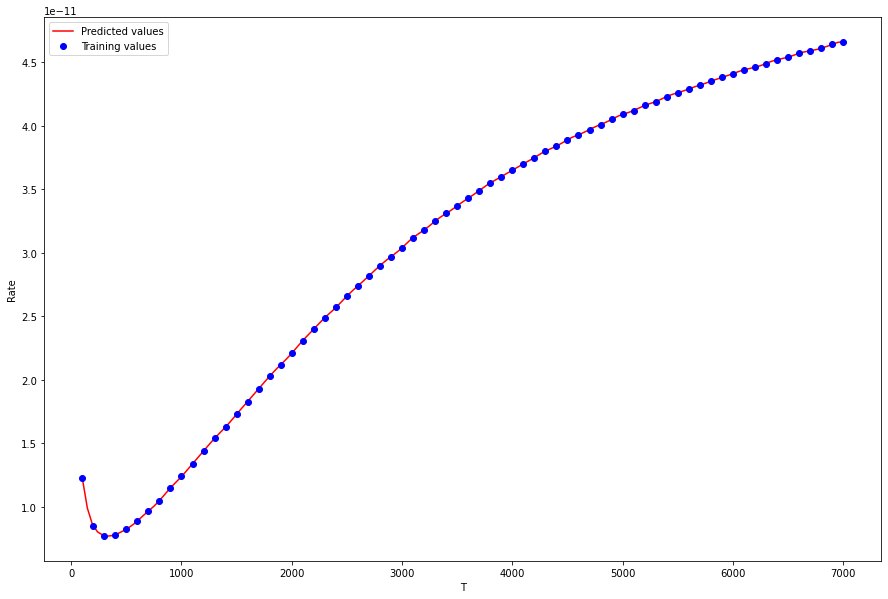

Xval range:  0.0 1.0
Yval range:  0.0 1.0
Start training 
Done 
Avg Stdev 6.84127e-05
Max Stdev 1.65526e-03


<Figure size 432x288 with 0 Axes>

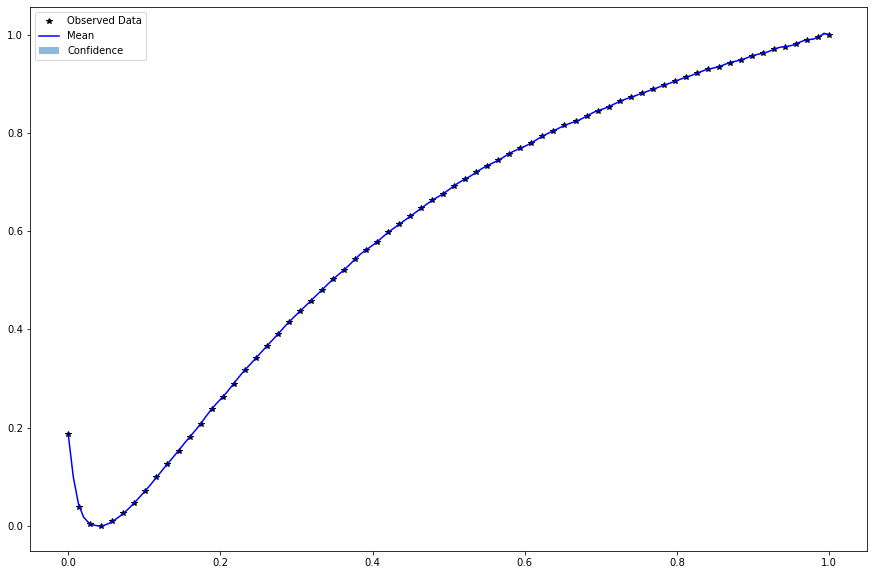

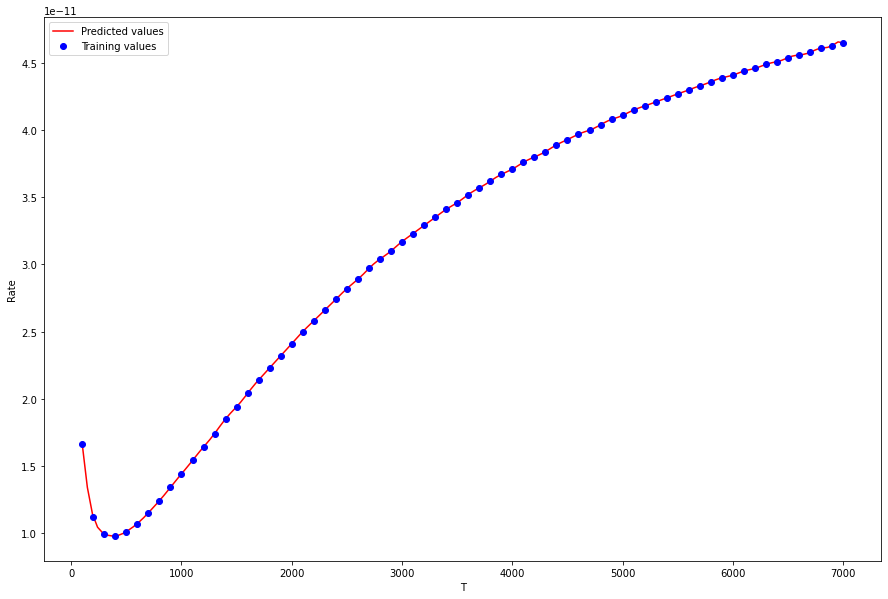

In [6]:
from sklearn.preprocessing import StandardScaler

normalizevalues = True

maxt = max(temp_values)
mint = min(temp_values)

for vibidx, selectedvib in enumerate(vib_values):
    train_x = []
    train_y = []

    maxy = float("-inf")
    miny = float("+inf")
    
    for idx, t in enumerate(temp_values):
        yval = df[t].values[vibidx]

        if yval < miny:
            miny = yval
        elif yval > maxy:
            maxy = yval

    for idx, t in enumerate(temp_values):
        tval = t 
        if normalizevalues:
            tval = (t - mint)/(maxt - mint)
        train_x.append(tval)
        
        yval = df[t].values[vibidx]
        #yval = math.log(yval)
        if normalizevalues:
            train_y.append((yval - miny)/(maxy - miny))
        else:
            train_y.append(yval)

    #print("V = " + str(selectedvib))
    minx = min(train_x)
    maxx = max(train_x)
    print("Xval range: ", minx, maxx)
    print("Yval range: ", min(train_y), max(train_y))

    #plt.title("V = " + str(selectedvib))
    #plt.scatter(train_x.numpy(), train_y.numpy())
    #plt.plot(train_x.numpy(), train_y.numpy())
    #plt.gcf().set_size_inches(15, 10)
    #plt.show()

    train_x = np.asarray(train_x).reshape(-1, 1)
    train_y = np.asarray(train_y)

    #print(train_x)
    #print(train_y)
    #scaler = StandardScaler()
    #print(scaler.fit_transform(train_x, train_y))

    model = fitusingscikitl (train_x, train_y, minx, maxx)
        
    #print(model.kernel)

    test_x = np.linspace(minx, maxx, 150).reshape(-1, 1)

    y_pred, std = model.predict(test_x, return_std=True)

    avgstdev = 0.0
    maxstd = float("-inf")
    lower = []
    upper = []
    for idx in range(len(y_pred)):
        val = 100.0 * (std[idx]/y_pred[idx])
        #print("%10.5e %10.5e %8.1f"%(y_pred[idx], std[idx], val))
        avgstdev += std[idx]
        if (std[idx] > maxstd):
            maxstd = std[idx]
        lower.append(y_pred[idx]-(2.0*std[idx]))
        upper.append(y_pred[idx]+(2.0*std[idx]))
    
    print("Avg Stdev %10.5e"%(avgstdev/float(len(y_pred))) )
    print("Max Stdev %10.5e"%(maxstd))

    """
    plt.plot(train_x, train_y, "bo", label="True values")
    plt.plot(test_x, y_pred, label="Predicted values")
    plt.errorbar(test_x, y_pred, std, marker='s', mfc='red', \
            mec='green', label="Predicted values")
    plt.xlabel("Normalized(T)")
    plt.ylabel("Normalized(Rate)")

    plt.gcf().set_size_inches(15, 10)
    plt.show()
    """

    plt.clf()
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    # Plot training data as black stars
    ax.plot(train_x, train_y, 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x, y_pred, 'b')
    # Shade between the lower and upper confidence bounds
    a = np.asarray(test_x).reshape(-1)
    b = np.asarray(lower)
    c = np.asarray(upper)
    ax.fill_between(a, b, c, alpha=0.5)
    # ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.gcf().set_size_inches(15, 10)
    plt.show()

    if normalizevalues:
        print()
        y_pred_true = (y_pred * (maxy - miny)) + miny
        test_x_true = (test_x * (maxt - mint)) + mint

        train_y_true = (train_y * (maxy - miny)) + miny
        train_x_true = (train_x * (maxt - mint)) + mint
        #std_true = (std * (maxy - miny)) + miny

        plt.clf()

        #plt.plot(test_x, y_pred, label="Predicted values")
        plt.plot(test_x_true, y_pred_true, 'r-', label="Predicted values")

        plt.plot(train_x_true, train_y_true, 'bo', label="Training values")
        plt.xlabel("T")
        plt.ylabel("Rate")
        plt.legend()

        plt.gcf().set_size_inches(15, 10)
        plt.show()
   